In [23]:
import math
import seaborn as sns
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

stock_data = yf.download('TTM', start='2016-01-01', end='2021-10-01')

[*********************100%***********************]  1 of 1 completed


In [24]:
stock_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-12-31,29.360001,29.620001,29.270000,29.469999,29.457693,569900
2016-01-04,28.299999,28.360001,27.760000,28.330000,28.318171,1442700
2016-01-05,28.120001,28.170000,27.400000,27.670000,27.658445,1898200
2016-01-06,27.049999,27.150000,26.740000,26.920000,26.908758,1533000
2016-01-07,25.620001,25.920000,25.129999,25.270000,25.259447,2118200


In [25]:
stock_data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-09-24,21.590000,21.879999,21.570000,21.799999,21.799999,1896800
2021-09-27,22.209999,22.950001,22.200001,22.809999,22.809999,5179400
2021-09-28,22.360001,22.559999,22.010000,22.070000,22.070000,2486100
2021-09-29,22.080000,22.400000,22.080000,22.330000,22.330000,819700
2021-09-30,22.400000,22.559999,22.260000,22.410000,22.410000,1686200


Text(0, 0.5, 'Prices ($)')

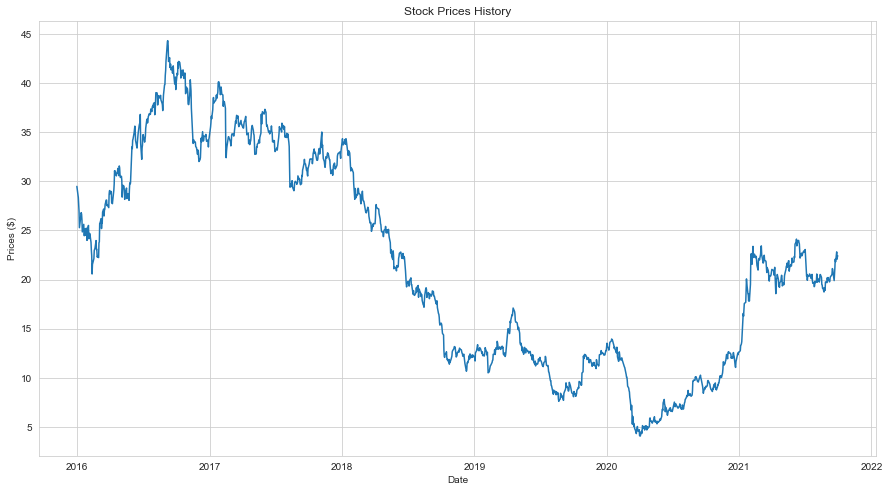

In [26]:
sns.set_style("whitegrid")
plt.figure(figsize=(15, 8))
plt.title('Stock Prices History')
plt.plot(stock_data['Close'])
plt.xlabel('Date')
plt.ylabel('Prices ($)')

In [27]:
close_prices = stock_data['Close']
values = close_prices.values
training_data_len = math.ceil(len(values)* 0.8)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))

train_data = scaled_data[0: training_data_len, :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [28]:
test_data = scaled_data[training_data_len-60: , : ]
x_test = []
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [29]:
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 60, 100)           40800     
                                                                 
 lstm_3 (LSTM)               (None, 100)               80400     
                                                                 
 dense_2 (Dense)             (None, 25)                2525      
                                                                 
 dense_3 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________


In [33]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 1, epochs=5)

Epoch 1/5
1099/1099 [==============================] - 54s 46ms/step - loss: 6.9981e-04
Epoch 2/5
1099/1099 [==============================] - 51s 47ms/step - loss: 5.4973e-04
Epoch 3/5
1099/1099 [==============================] - 50s 45ms/step - loss: 4.7900e-04 1s - loss: 4.887
Epoch 4/5
1099/1099 [==============================] - 59s 53ms/step - loss: 4.5171e-04
Epoch 5/5
1099/1099 [==============================] - 51s 47ms/step - loss: 5.2052e-04


In [31]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

0.19314811138958254

C:\Users\yashp\OneDrive\anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


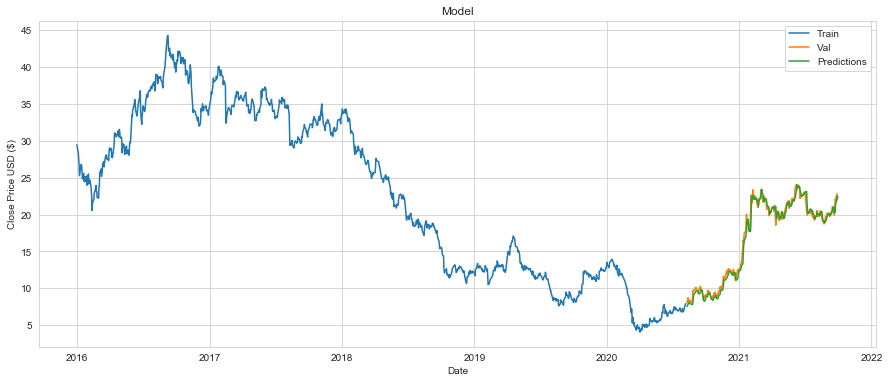

In [35]:
data = stock_data.filter(['Close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(15,6))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='upper right')
plt.show()